In [ ]:
!git clone https://github.com/AarohiSingla/Image-Classification-Using-Vision-transformer

Cloning into 'Image-Classification-Using-Vision-transformer'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 43 (delta 12), reused 8 (delta 8), pack-reused 29
Receiving objects: 100% (43/43), 862.14 KiB | 5.35 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [ ]:
code = '''

# _scheduler has been added

import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def val_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    # Put model in eval mode
    model.eval()

    # Setup val loss and val accuracy values
    val_loss, val_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            val_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            # Calculate and accumulate accuracy
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          scheduler: torch.optim.lr_scheduler._LRScheduler,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": [],
               "learning_rates": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and validation steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        val_loss, val_acc = val_step(model=model,
          dataloader=val_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Store the current learning rate
        current_lr = optimizer.param_groups[0]['lr']

        if scheduler:
          scheduler.step(val_acc)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"val_loss: {val_loss:.4f} | "
          f"val_acc: {val_acc:.4f} |"
          f"lr: {current_lr}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)
        results["learning_rates"].append(current_lr)

    # Return the filled results at the end of the epochs
    return model, results

'''

with open('/content/Image-Classification-Using-Vision-transformer/going_modular/going_modular/engine.py', 'w') as file:
    file.write(code)

In [ ]:
!pip install torchinfo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [ ]:
!unzip '/content/drive/MyDrive/Thesis/C_NMC_2019_dataset.zip'
# !unzip '/content/drive/MyDrive/flowers.v1i.folder.zip'
from google.colab import output
output.clear()

# Pretrained Model

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau


import sys
sys.path.append('/content/Image-Classification-Using-Vision-transformer')

from helper_functions import set_seeds

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 3.1. Unfreeze the last three layers
num_layers = len(pretrained_vit.encoder.layers)
for block in pretrained_vit.encoder.layers[-1:]:
    for param in block.parameters():
        param.requires_grad = True

# 3.2. Unfreeze LayerNorm
for param in pretrained_vit.encoder.ln.parameters():
    param.requires_grad = True

# 4. Change the classifier head
class_names = ['ALL','hem']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 146MB/s]


In [ ]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              Partial
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   Partial
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [

In [ ]:
train_dir = '/content/C_NMC_2019_dataset/training'
val_dir = '/content/C_NMC_2019_dataset/validation'

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    val_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  val_data = datasets.ImageFolder(val_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  val_dataloader = DataLoader(
      val_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, val_dataloader, class_names

In [ ]:
# Setup dataloaders
train_dataloader_pretrained, val_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     val_dir=val_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [ ]:
from going_modular.going_modular import engine

# Create optimizer and loss function

optimizer = torch.optim.Adamax(params=pretrained_vit.parameters(),
                             lr=1e-3, weight_decay=0.0001)

loss_fn = torch.nn.CrossEntropyLoss()

# loss_fn = torch.nn.BCEWithLogitsLoss()


scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=1, verbose=True)


# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
model, pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      val_dataloader=val_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=8,
                                      scheduler=scheduler,
                                      device=device)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3585 | train_acc: 0.8381 | val_loss: 0.2723 | val_acc: 0.8894 |lr: 0.001
Epoch: 2 | train_loss: 0.2342 | train_acc: 0.9015 | val_loss: 0.2789 | val_acc: 0.8853 |lr: 0.001


In [ ]:
torch.save(model, 'pretrained_vit_model.pth')


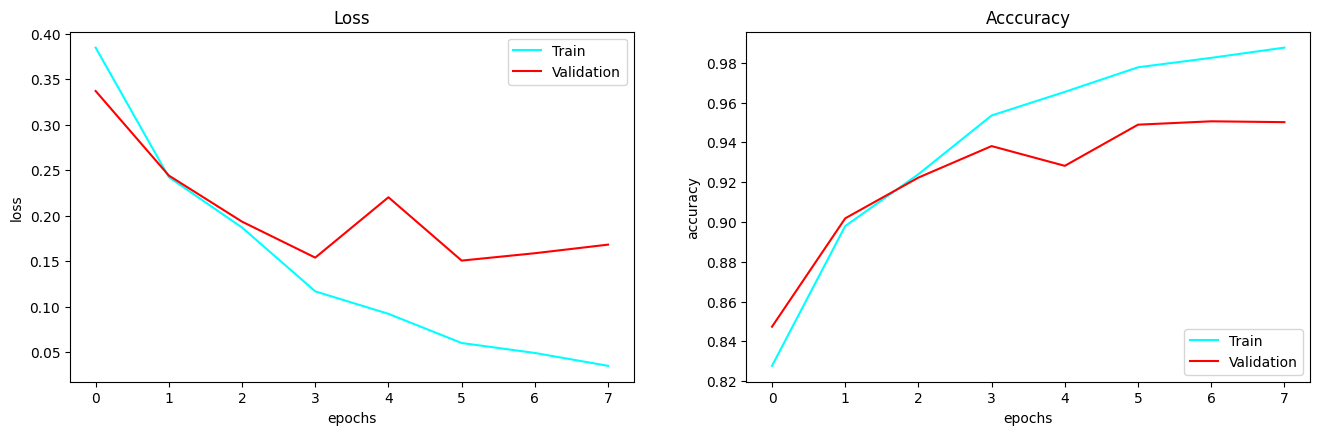

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))

plt.subplot(2, 2, 1)
plt.plot(pretrained_vit_results['train_loss'], color='cyan')
plt.plot(pretrained_vit_results['val_loss'], color='red')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')


plt.subplot(2, 2, 2)
plt.plot(pretrained_vit_results['train_acc'], color='cyan')
plt.plot(pretrained_vit_results['val_acc'], color='red')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Acccuracy')
plt.legend(['Train', 'Validation'], loc='lower right')


plt.subplots_adjust(wspace=0.2)




In [ ]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adamax(params=pretrained_vit.parameters(),
                             lr=1e-3, weight_decay=0.0004)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.4, patience=1, verbose=True)
loss_fn = torch.nn.CrossEntropyLoss()
# loss_fn = torch.nn.BCEWithLogitsLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
model, pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      val_dataloader=val_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=8,
                                      scheduler=scheduler,
                                      device=device)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3709 | train_acc: 0.8328 | val_loss: 0.2980 | val_acc: 0.8754 |lr: 0.001
Epoch: 2 | train_loss: 0.2335 | train_acc: 0.9028 | val_loss: 0.2260 | val_acc: 0.8980 |lr: 0.001
Epoch: 3 | train_loss: 0.1808 | train_acc: 0.9261 | val_loss: 0.2271 | val_acc: 0.9092 |lr: 0.001
Epoch: 4 | train_loss: 0.1170 | train_acc: 0.9525 | val_loss: 0.1557 | val_acc: 0.9364 |lr: 0.0004
Epoch: 5 | train_loss: 0.0932 | train_acc: 0.9640 | val_loss: 0.1625 | val_acc: 0.9411 |lr: 0.0004
Epoch: 6 | train_loss: 0.0624 | train_acc: 0.9755 | val_loss: 0.1581 | val_acc: 0.9474 |lr: 0.00016
Epoch: 7 | train_loss: 0.0528 | train_acc: 0.9791 | val_loss: 0.1708 | val_acc: 0.9472 |lr: 0.00016
Epoch: 8 | train_loss: 0.0374 | train_acc: 0.9856 | val_loss: 0.1935 | val_acc: 0.9464 |lr: 6.400000000000001e-05


In [ ]:
torch.save(model, '/content/drive/MyDrive/pretrained_vit_model.pth')


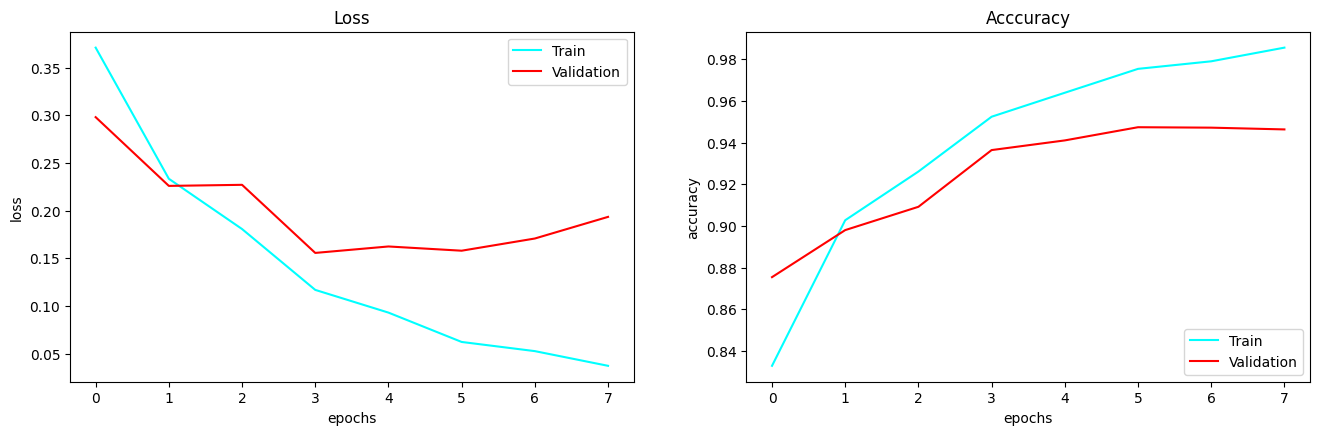

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))

plt.subplot(2, 2, 1)
plt.plot(pretrained_vit_results['train_loss'], color='cyan')
plt.plot(pretrained_vit_results['val_loss'], color='red')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')


plt.subplot(2, 2, 2)
plt.plot(pretrained_vit_results['train_acc'], color='cyan')
plt.plot(pretrained_vit_results['val_acc'], color='red')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Acccuracy')
plt.legend(['Train', 'Validation'], loc='lower right')


plt.subplots_adjust(wspace=0.2)




In [ ]:
model = torch.load("/content/drive/MyDrive/Thesis/saved_models/pretrained_vit_model9502.pth")
